# Задание 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge

In [2]:
def metric(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

In [3]:
def get_volume(s):
    number = list(map(int, re.findall(r'[0-9]+', s.split('-')[-1])))

    if len(number) != 0:
        if number[0] > 350:
            return number[0]
        elif len(number) == 2:
            return number[0]*1000 + number[1]*10
        elif len(number) == 1 and number[0] < 20:
            return number[0] * 30
        else:
            return 0
    else:
        return 0

In [4]:
def get_valid_code(code):
    if code > 0 and code < 100000:
        return 1
    elif code < 450000 and code > 270000:
        return 1
    else:
        return 0

In [5]:
DATA = 'junior/'
SEED = 96

In [6]:
df_reg = pd.read_csv(DATA + 'regression/data_regression_for_task.csv', na_values=['BC', 'WC'])

Приведем все названя колонок к строчномц виду и посомтрим корреляционную матрицу, что бы лучше понять зависимости между признаками

In [7]:
df_reg.columns = list(map(lambda x: x.lower(), df_reg.columns))

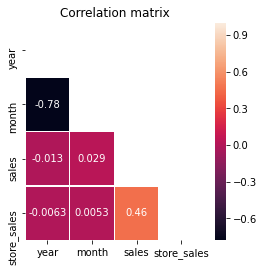

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(df_reg.corr(), mask=np.triu(df_reg.corr()), annot=True, linewidth=.4)
ax.set_title('Correlation matrix')
plt.show()

Заполним все пропуски в `article_code` нулями. Это необходимо что бы данные можно было использовать в разных модклях. Так же приведем этот параметр к типу `int` что бы можно было его проще анализировать. Для параметра `store_sales` сделаем все значения положительными с помощью `abs`

In [9]:
df_reg['article_code'].fillna(0, inplace=True)

In [10]:
df_reg['article_code'] = df_reg['article_code'].astype('str').apply(lambda x: x[:-1] if x[-1] == 'A' else x)

In [11]:
df_reg['article_code'] = df_reg['article_code'].apply(int)

In [12]:
df_reg['store_sales'] = df_reg['store_sales'].apply(abs)

Посмотрим как распределены некоторые признаки

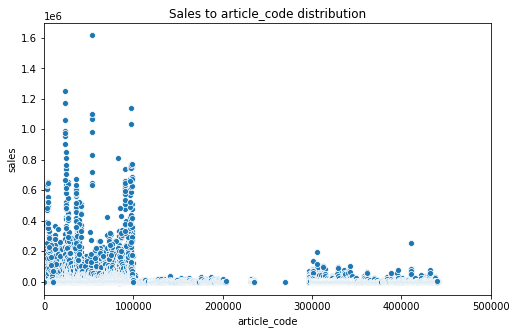

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df_reg, y='sales', x='article_code')
ax.set_xlim((0, .5e6))
plt.title('Sales to article_code distribution')
plt.show()

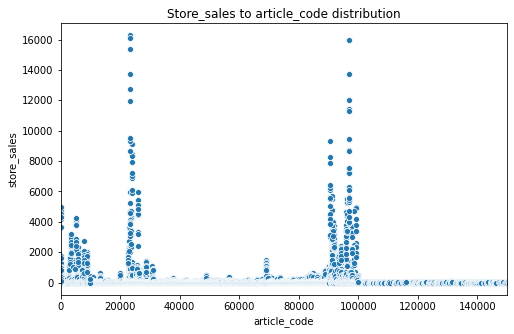

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df_reg, y='store_sales', x='article_code')
ax.set_xlim((0, .15e6))
plt.title('Store_sales to article_code distribution')
plt.show()

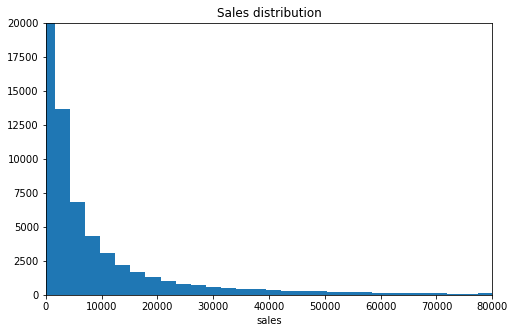

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.hist(df_reg['sales'], bins=600)
ax.set_xlim((0, .08e6))
ax.set_ylim((0, 20000))
ax.set_xlabel('sales')
plt.title('Sales distribution')
plt.show()

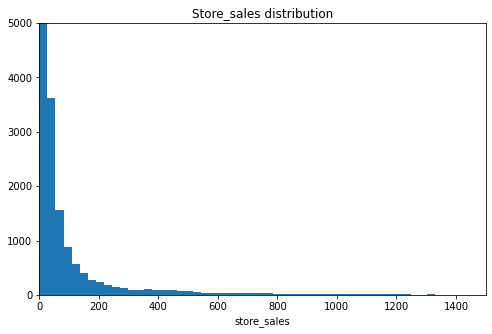

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.hist(df_reg['store_sales'], bins=600)
ax.set_xlim((0, 1500))
ax.set_ylim((0, 5000))
ax.set_xlabel('store_sales')
plt.title('Store_sales distribution')
plt.show()

Сделаем энеодинг категориальных признаков `contragent` и `article_group`. Поскольку не предполагается использование линейных моделей, моэно использовать целочисленное кодирование. Если бы необходимо было использовать линейные модели то моэно было бы кодировать срежним значением таргета или другого признака.

In [17]:
df_reg['contragent'] = df_reg['contragent'].astype('category').cat.codes

In [18]:
df_reg['article_group'] = df_reg['article_group'].astype('category').cat.codes

Важным признаком в нашей моделе является `store_sales` поэтому будет правильным сделать несоклько производных признаков на основании этого. Такими признаками станут `total_store_sales`, `mean_store_sales`, `group_store_sales`, `total_agent_store_sales`. Они соответствуют общим продажам в магазинах по товару, средним продажам по товару в магазинах, общим продажам в магазинах по категории товаров, общим продажам в магахинах по поставщику.

In [19]:
total_store_sales = df_reg[['article_code', 'store_sales']].groupby(
    ['article_code']).sum().rename(columns={'store_sales': 'total_store_sales'})
df_reg = df_reg.merge(total_store_sales, on='article_code', how='left')

In [20]:
mean_store_sales = df_reg[['article_code', 'store_sales']].groupby(
    ['article_code']).mean().rename(columns={'store_sales': 'mean_store_sales'})
df_reg = df_reg.merge(mean_store_sales, on='article_code', how='left')

In [21]:
group_store_sales = df_reg[['article_group', 'store_sales']].groupby(
    'article_group').sum().rename(columns={'store_sales': 'group_store_sales'})
df_reg = df_reg.merge(group_store_sales, on='article_group', how='left')

In [22]:
total_agent_store_sales = df_reg[['contragent', 'store_sales']].groupby(
    ['contragent']).sum().rename(columns={'store_sales': 'total_agent_store_sales'})
df_reg = df_reg.merge(total_agent_store_sales, on='contragent', how='left')

Ещё один признак с которым надо что-то сделать это признак `article_name`. Поскольку это строка, почти каждая строка уникальна, поэтому надо вытащить из этой строки какие-то данные которые будут менее уникальными. Таким признаком может быть обьем товара. Дастать обьем можно с помощью функции `get_volume`. Она не идеальна, но для большинства строк она работает корректно.

In [23]:
df_reg['volume'] = df_reg['article_name'].apply(get_volume)

Если построить диаграмму рассеяния для параметров `article_code` и `sales` можно заметить что у товаров, у которых `article_code` находится от 0 до 100000 и от 270000 до 450000 параметр `sales` значительно больше чем у других. Введем дополнительный бинарный признак, который будет отвечать за то что `article_code` лежит в нужных пределах

In [24]:
df_reg['valid_code'] = df_reg['article_code'].apply(get_valid_code)

In [25]:
df_reg.drop(columns=['article_name'], inplace=True)

Разделим выборку на обучающую и тестовую

In [26]:
test = df_reg.loc[(df_reg['year'] == 2018) & (df_reg['month'] == 2)]
train = df_reg.loc[~((df_reg['year'] == 2018) & (df_reg['month'] == 2))]

In [27]:
X_train, y_train = train.drop(columns='sales'), train['sales']
X_test, y_test = test.drop(columns='sales'), test['sales']

Я попробовал несколько регрессоров (`XGBoostRegressor`, `RandomForestRegressor`, `LinearRegression`) но лучше всех себя показала `KNeighborsRegressor` в состоянии "из коробки".

In [28]:
knn = KNeighborsRegressor()

In [29]:
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [30]:
kpred = knn.predict(X_test)

In [31]:
metric(y_test, kpred)

35.24026705624515

После того как я получил значение метрики для обученной модели я попробовал оптиимзировать гиперпараметры модели с помощью `GridSearchCV` но какие бы значения я не передавал в оптимизатор финальная модель не показывала точность лучше чем коробочная. По этому я оставил коробочную

# Задание 2

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

from xgboost import XGBClassifier, plot_importance

In [33]:
DATA = 'junior/'
SEED = 96

In [34]:
df_cls = pd.read_csv(DATA + 'classification/data_classification_for_task.csv')

Приведем все названя колонок к строчномц виду и посомтрим корреляционную матрицу, что бы лучше понять зависимости между признаками

In [35]:
df_cls.columns = list(map(lambda x: x.lower(), df_cls.columns))

Посмотрим как распределены признаки и какие уникальные значения они принимают 

In [36]:
df_cls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         303 non-null    int64  
 1   gender      303 non-null    int64  
 2   feature_1   303 non-null    int64  
 3   feature_2   303 non-null    int64  
 4   feature_3   303 non-null    int64  
 5   feature_4   303 non-null    int64  
 6   feature_5   303 non-null    int64  
 7   feature_6   303 non-null    int64  
 8   feature_7   303 non-null    int64  
 9   feature_8   303 non-null    float64
 10  feature_9   303 non-null    int64  
 11  feature_10  303 non-null    int64  
 12  feature_11  303 non-null    int64  
 13  target      303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Визуализируем несколько признаков для лучшего понимания данных

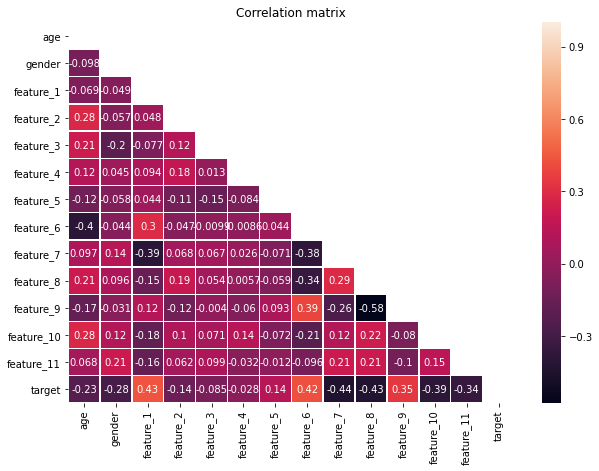

In [37]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df_cls.corr(), mask=np.triu(df_cls.corr()), annot=True, linewidth=.4)
ax.set_title('Correlation matrix')
plt.show()

In [38]:
df_cls['feature_1'].unique()

array([3, 2, 1, 0])

In [39]:
df_cls['feature_4'].unique()

array([1, 0])

In [40]:
df_cls['feature_5'].unique()

array([0, 1, 2])

Судя по структуре датасета и значениям которые принимают параметры можно предполоджить что этот датасет называется Heart Disease от UCI. Исходя из этого предположения переименуем признаки и приведем некоторые из них в категориальные. После чего к категориальным признакам применим One Hot Encoding. Такая кодировка положительно скажется на разделительной способности модели которую мы будем использовать  

In [41]:
df_cls.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 
                  'cholesterol', 'fasting_blood_sugar', 'rest_ecg','max_heart_rate_achieved', 
                  'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels',
                  'thalassemia', 'target']

In [42]:
obj = ['chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'st_slope', 'thalassemia']
for col in df_cls.columns:
    if col in obj:
        df_cls[col] = df_cls[col].astype('object')

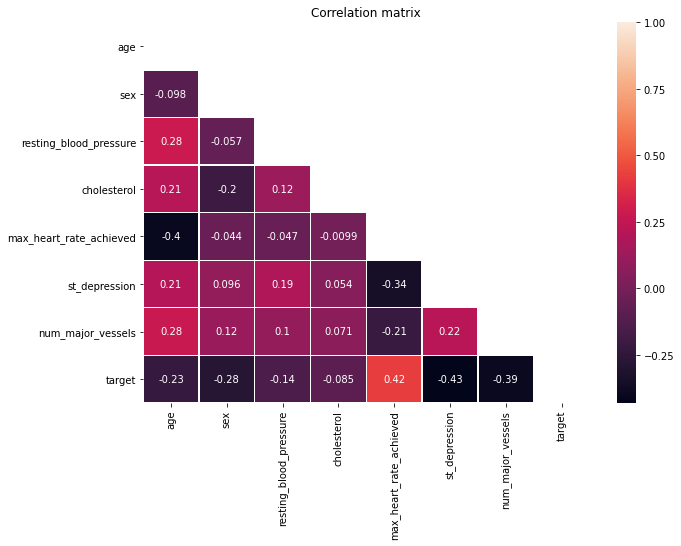

In [43]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df_cls.corr(), mask=np.triu(df_cls.corr()), annot=True, linewidth=.4)
ax.set_title('Correlation matrix')
plt.show()

Посмотрим есть ли разница в распределении признака `max_heart_rate_achieved`, потому что у него самамя большая оценка коэффициента корреляци среди всех признаков. Как видно из графика, для `target == 1`распределение действительно сдвинуто вправо

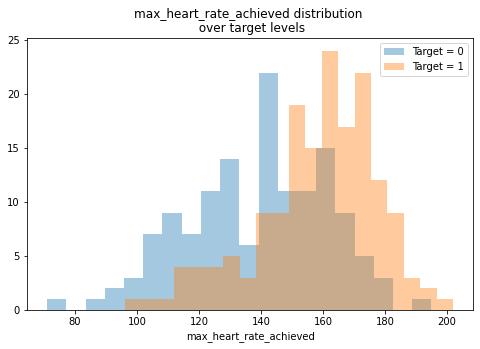

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(df_cls.loc[df_cls['target'] == 0, 'max_heart_rate_achieved'], kde=False, label='Target = 0', bins=20)
sns.distplot(df_cls.loc[df_cls['target'] == 1, 'max_heart_rate_achieved'], kde=False, label='Target = 1', bins=20)
plt.legend()
ax.set_title('max_heart_rate_achieved distribution \n over target levels')
plt.show()

По распределению параметра `age` тоже видно что оно меняется в зависимости от уровня `target`

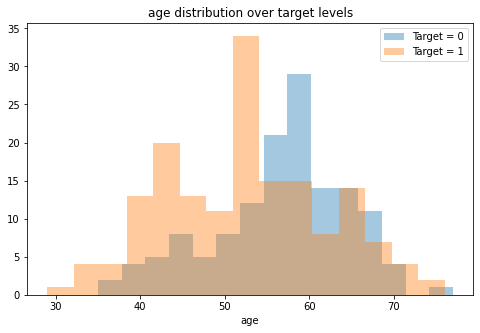

In [45]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(df_cls.loc[df_cls['target'] == 0, 'age'], kde=False, label='Target = 0', bins=15)
sns.distplot(df_cls.loc[df_cls['target'] == 1, 'age'], kde=False, label='Target = 1', bins=15)
plt.legend()
ax.set_title('age distribution over target levels')
plt.show()

Из общей логики посмотрим как распределение параметра `resting_blood_pressure` меняется от уровня `target`. Как оказывается этот признак не является хорошим разделяющим параметром. Но для модели этот признак является одним из самых важных

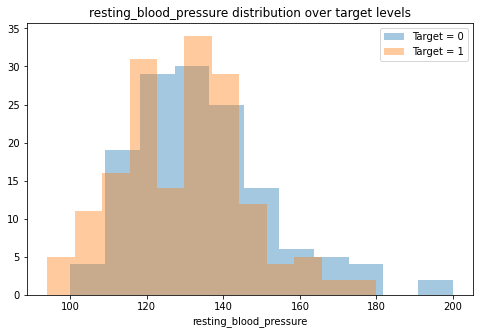

In [46]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(df_cls.loc[df_cls['target'] == 0, 'resting_blood_pressure'], kde=False, label='Target = 0')
sns.distplot(df_cls.loc[df_cls['target'] == 1, 'resting_blood_pressure'], kde=False, label='Target = 1')
plt.legend()
ax.set_title('resting_blood_pressure distribution over target levels')
plt.show()

In [47]:
df_cls = pd.get_dummies(df_cls)

Разделим выборку на обучающую и тестовую. Обучим модель и посмотрим на результат

In [48]:
X, y = df_cls.iloc[:, :-1], df_cls.iloc[:, -1]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, random_state=SEED)

In [50]:
boost = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

In [51]:
boost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [52]:
bp = boost.predict(X_test)

In [53]:
f1_score(y_test, bp)

0.9811320754716981